# Install Dependencies

In [1]:
!pip install torch_summary

# Import Libraries

In [2]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms as T, models
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm.notebook import tqdm 

from sklearn.metrics import classification_report, recall_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle, randint, choice
import numpy as np
import cv2 as cv
from glob import glob
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!mkdir saved_model
sns.set_theme()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [4]:
G1020 = '/kaggle/input/glaucoma-datasets/G1020'

G1020_df = pd.read_csv(f'{G1020}/G1020.csv', index_col=0).reset_index()

G1020_df.head()

,imageID,binaryLabels
0,image_0.jpg,0
1,image_1.jpg,0
2,image_3.jpg,0
3,image_4.jpg,0
4,image_5.jpg,0


In [5]:
G1020_df['filepath'] = G1020_df['imageID'].apply(lambda x: '/kaggle/input/glaucoma-datasets/G1020/Images/' + x)

G1020_df.head()

,imageID,binaryLabels,filepath
0,image_0.jpg,0,/kaggle/input/glaucoma-datasets/G1020/Images/i...
1,image_1.jpg,0,/kaggle/input/glaucoma-datasets/G1020/Images/i...
2,image_3.jpg,0,/kaggle/input/glaucoma-datasets/G1020/Images/i...
3,image_4.jpg,0,/kaggle/input/glaucoma-datasets/G1020/Images/i...
4,image_5.jpg,0,/kaggle/input/glaucoma-datasets/G1020/Images/i...


In [6]:
ORIGA = '/kaggle/input/glaucoma-datasets/ORIGA'

ORIGA_df = pd.read_csv(f'{ORIGA}/origa_info.csv', index_col=0).reset_index()

ORIGA_df.head()

,Image,Source,Cropped,CDR,Ecc-Cup,Ecc-Disc,Label
0,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.7097,0.636027,0.580909,0
1,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.6953,0.575024,0.608413,0
2,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.9629,0.299303,0.262828,0
3,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.7246,0.503186,0.483273,0
4,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.6138,0.500141,0.283467,0


In [7]:
ORIGA_df['filepath'] = ORIGA_df['Image'].apply(lambda x: '/kaggle/input/glaucoma-datasets/ORIGA/Images/' + x.split('/')[-1])

ORIGA_df.head()

,Image,Source,Cropped,CDR,Ecc-Cup,Ecc-Disc,Label,filepath
0,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.7097,0.636027,0.580909,0,/kaggle/input/glaucoma-datasets/ORIGA/Images/0...
1,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.6953,0.575024,0.608413,0,/kaggle/input/glaucoma-datasets/ORIGA/Images/0...
2,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.9629,0.299303,0.262828,0,/kaggle/input/glaucoma-datasets/ORIGA/Images/0...
3,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.7246,0.503186,0.483273,0,/kaggle/input/glaucoma-datasets/ORIGA/Images/0...
4,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.6138,0.500141,0.283467,0,/kaggle/input/glaucoma-datasets/ORIGA/Images/0...


In [8]:
full_df = pd.DataFrame()
full_df['filepath'] = G1020_df['filepath'].tolist() + ORIGA_df['filepath'].tolist()
full_df['label'] = G1020_df['binaryLabels'].tolist() + ORIGA_df['Label'].tolist()
full_df.sample(frac=1)
full_df.head()

,filepath,label
0,/kaggle/input/glaucoma-datasets/G1020/Images/i...,0
1,/kaggle/input/glaucoma-datasets/G1020/Images/i...,0
2,/kaggle/input/glaucoma-datasets/G1020/Images/i...,0
3,/kaggle/input/glaucoma-datasets/G1020/Images/i...,0
4,/kaggle/input/glaucoma-datasets/G1020/Images/i...,0


(-0.5, 3003.5, 2422.5, -0.5)

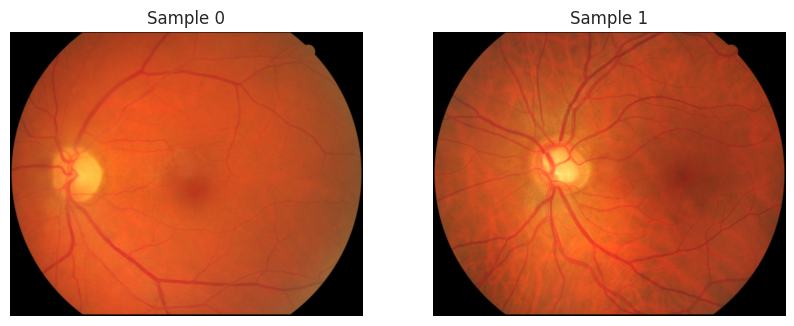

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# 0
imgpath = full_df[full_df['label']==0].sample(1)['filepath'].values[0]
img = Image.open(f'{imgpath}')
ax[0].imshow(img)
ax[0].set_title('Sample 0')
ax[0].axis('off')

# 1
imgpath = full_df[full_df['label']==1].sample(1)['filepath'].values[0]
img = Image.open(f'{imgpath}')
ax[1].imshow(img)
ax[1].set_title('Sample 1')
ax[1].axis('off')

# Split Dataset

In [10]:
label0_df = full_df[full_df['label'] == 0]
label1_df = full_df[full_df['label'] == 1]

label0_train, label0_valid = train_test_split(label0_df, test_size=0.2, random_state=42)
label1_train, label1_valid = train_test_split(label1_df, test_size=0.2, random_state=42)

train_df = pd.concat([label0_train, label1_train]).sample(frac=1, random_state=42)
valid_df = pd.concat([label0_valid, label1_valid]).sample(frac=1, random_state=42)

# Prepare Dataset and Dataloader

In [11]:
class EyeDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.transform = T.Compose([
            T.Resize([224, 224]),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406),
                       (0.229, 0.224, 0.225))
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        filepath = f"{self.df.iloc[idx]['filepath']}"
#         image = Image.open(filepath)
        image = cv.imread(filepath)
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        image = cv.cvtColor(image, cv.COLOR_GRAY2RGB)
        image = Image.fromarray(image)
        target = self.df.iloc[idx]['label']
        
        return image, target
    
    def transform_img(self, img):
        return self.transform(img)
    
    def collate_fn(self, data):
        imgs, targets = zip(*data)
        targets = torch.tensor(targets)
        targets = targets.view(-1, 1).float()
        targets = targets.to(device)
        imgs = torch.stack(
            [self.transform_img(img) for img in imgs], 0
        ).to(device)
        return imgs, targets

In [12]:
train_ds = EyeDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,
                      collate_fn=train_ds.collate_fn, 
                      drop_last=True)

valid_ds = EyeDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=64,
                      collate_fn=valid_ds.collate_fn)

In [13]:
print('Size of Train:', len(train_ds))
print('Size of Validation:', len(valid_ds))

Size of Train: 1335
Size of Validation: 335


# Model

In [14]:
class EyeClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.model = models.resnet50(pretrained=pretrained, progress=pretrained)
        for param in self.model.parameters():
            param.requires_grad = True
        
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.5),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.BatchNorm1d(num_features),
#             nn.Dropout(0.5),
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [15]:
classifier = EyeClassifier(pretrained=True)
_ = summary(classifier, torch.ones(1,3,224,224))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 299MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 28, 28] 

# Define Train and Validate Functions

In [16]:
def train(data, classifier, optimizer, loss_fn):
    classifier.train()
    imgs, targets = data
    outputs = classifier(imgs.to(device))
    loss = loss_fn(outputs.to(device), targets.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    outputs = outputs.cpu().detach().tolist()
    targets = targets.cpu().detach().tolist()
    preds = list(map(lambda x: int(x[0] > 0.5), outputs))
    fake_recall_score = recall_score(targets, preds, 
                               pos_label=0,
                               zero_division=0)
    
    return loss.cpu().detach().item(), fake_recall_score

In [17]:
@torch.no_grad()
def validate(data, classifier, loss_fn):
    classifier.eval()
    imgs, targets = data
    outputs = classifier(imgs.to(device))
    loss = loss_fn(outputs.to(device), targets.to(device))
    
    outputs = outputs.cpu().detach().tolist()
    targets = targets.cpu().detach().tolist()
    preds = list(map(lambda x: int(x[0] > 0.5), outputs))
    fake_recall_score = recall_score(targets, preds, 
                               pos_label=0,
                               zero_division=0)
    
    return loss.cpu().detach().item(), fake_recall_score

In [18]:
classifier = EyeClassifier(pretrained=True).to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=5e-4, weight_decay=1e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3,
                                      gamma=0.25)
best_recall_score = 0
n_epochs = 10
xticks = list(i+1 for i in range(n_epochs))

In [19]:
mem = {
    'train_loss': [],
    'train_recall_score': [],
    'valid_loss': [],
    'valid_recall_score': []
}

for epoch in tqdm(range(n_epochs), desc='Training'):
    n_batch = len(train_dl)
    train_losses, train_recall_scores = [], []
    for i, data in enumerate(train_dl):
        train_loss, train_recall_score = train(data, classifier,
                                         optimizer, loss_fn)
        train_losses.append(train_loss)
        train_recall_scores.append(train_recall_score)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\ttrain loss:', "%.3f" % train_loss,
            '\ttrain recall score:', "%.3f" % train_recall_score, 
            end='\r'
        )
        
    mem['train_loss'].append(np.mean(train_losses))
    mem['train_recall_score'].append(np.mean(train_recall_scores))
    
    n_batch = len(valid_dl)
    valid_losses, valid_recall_scores = [], []
    for i, data in enumerate(valid_dl):
        valid_loss, valid_recall_score = validate(data, classifier, loss_fn)
        valid_losses.append(valid_loss)
        valid_recall_scores.append(valid_recall_score)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\tvalid loss:', "%.3f" % valid_loss,
            '\tvalid recall score:', "%.3f" % valid_recall_score, 
            end='\r'
        )
    
    cur_recall_score = np.mean(valid_recall_scores)
    mem['valid_loss'].append(np.mean(valid_losses))
    mem['valid_recall_score'].append(cur_recall_score)
    
    print(
        'epoch:', epoch+1,
        '\ttrain loss:', "%.3f" % mem['train_loss'][-1],
        '\ttrain recall score:', "%.3f" % mem['train_recall_score'][-1],
        '\tvalid loss:', "%.3f" % mem['valid_loss'][-1],
        '\tvalid recall score:', "%.3f" % mem['valid_recall_score'][-1],
    )
    
    if best_recall_score < cur_recall_score:
        best_recall_score = cur_recall_score
        torch.save(classifier.state_dict(), './saved_model/glaucoma_state_dict.pth')
        torch.save(classifier, './saved_model/glaucoma_model.pth')
        
    scheduler.step()

Training:   0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 	train loss: 0.873 	train recall score: 0.542 	valid loss: 0.722 	valid recall score: 0.791
epoch: 2 	train loss: 0.703 	train recall score: 0.644 	valid loss: 0.880 	valid recall score: 0.754
epoch: 3 	train loss: 0.638 	train recall score: 0.729 	valid loss: 0.681 	valid recall score: 0.810
epoch: 4 	train loss: 0.560 	train recall score: 0.774 	valid loss: 0.625 	valid recall score: 0.756
epoch: 5 	train loss: 0.493 	train recall score: 0.832 	valid loss: 0.904 	valid recall score: 0.536
epoch: 6 	train loss: 0.412 	train recall score: 0.850 	valid loss: 0.840 	valid recall score: 0.685
epoch: 7 	train loss: 0.271 	train recall score: 0.926 	valid loss: 0.735 	valid recall score: 0.767
epoch: 8 	train loss: 0.195 	train recall score: 0.957 	valid loss: 0.935 	valid recall score: 0.685
epoch: 9 	train loss: 0.142 	train recall score: 0.976 	valid loss: 0.901 	valid recall score: 0.755
epoch: 10 	train loss: 0.095 	train recall score: 0.993 	valid loss: 0.998 	valid recall sc

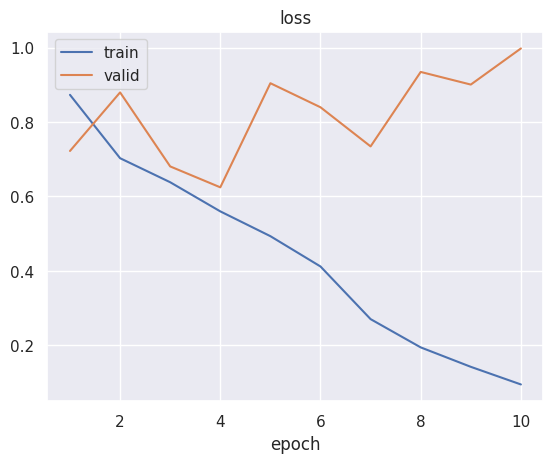

In [20]:
plt.plot(xticks, mem['train_loss'])
plt.plot(xticks, mem['valid_loss'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('loss')
plt.show()

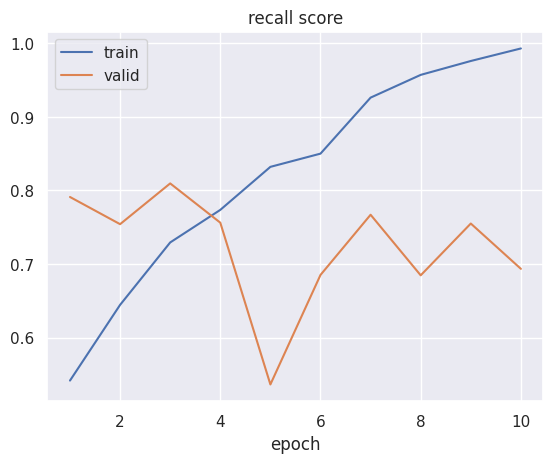

In [21]:
plt.plot(xticks, mem['train_recall_score'])
plt.plot(xticks, mem['valid_recall_score'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('recall score')
plt.show()